### Imports and configuration

In [1]:
%matplotlib inline

import geopandas as gpd
import matplotlib
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import pickle
import rasterio as rio

from matplotlib.patches import Rectangle
from rasterio.enums import Resampling
from sklearn.metrics import mean_squared_error

matplotlib.rc('animation', html='jshtml')
matplotlib.rc('animation', embed_limit=1000)
matplotlib.rc('figure', dpi=150)

transition_cmap = matplotlib.colors.ListedColormap(['blue', 'green', 'orange'])

### Helper functions

In [2]:
# proj crs NAD 1983 UTM Zone 18N
# geographic crs NAD 1983

def couple_transition_anim(surge_inun, riv_inun, ratio_array, alpha):

    # earlier operations moved out of the loop for performance

    # vary alpha (see eqn. 2 from SI 2022 paper)
    # calculate compound inundation accounting for transition zone
    # implement eqn. 2 from SI 2022 paper
    compound_inun = np.where(
        (ratio_array > 1) & (surge_inun != 0), # coastal zone
        0,
        np.where(
            (ratio_array <= alpha*riv_inun) & (riv_inun != 0), # hydrologic zone
            1,
            np.where(
                (ratio_array <= 1 & (ratio_array > alpha*riv_inun)) & (surge_inun != 0) & (riv_inun != 0), # transition zone
                2,
                np.nan, # else assign NaN
        )))

    return np.ma.masked_array(compound_inun,msk)

def notnan(a):
    return a[~np.isnan(a)]

### Read and clean input datasets

In [3]:
surge_fpath = 'data_github/florence_surge_nhc_max_internal_mask.tif'
riv_fpath = 'data_github/030202_201809192100_depth_map_projUTM18n.tif'

with rio.open(surge_fpath) as ds_in:
    surge_inun = ds_in.read(1, masked=True)
    surge_inun_profile = ds_in.profile
msk = surge_inun.copy().mask # save mask, will get wiped out on next lines
surge_inun[surge_inun>3.4e+38] = np.nan # set nodata
surge_inun[surge_inun < 0] = np.nan
surge_inun = np.ma.masked_array(surge_inun, msk)
# save mask with GDAL convetion for writing later
# https://rasterio.readthedocs.io/en/latest/topics/masks.html
w_msk = (~surge_inun.mask * 255).astype('uint8')

with rio.open(riv_fpath) as ds_in:
    riv_inun = ds_in.read(1, masked=True)
riv_inun[riv_inun>3.4e+38] = np.nan # set nodata
riv_inun[riv_inun<0] = np.nan

# give riv_inun one extra row and col to match shapes with surge_inun
# this is due to how ArcGIS projected raster
# extra row and col will get masked out when written to .tif
# newrow = np.empty(riv_inun.shape[1])
# newrow.fill(np.nan)
# riv_inun = np.vstack([riv_inun,newrow])

# newcol = np.empty([riv_inun.shape[0],1])
# newcol.fill(np.nan)
# riv_inun = np.hstack([riv_inun,newcol])

newrow = np.empty(riv_inun.shape[1])
newrow.fill(np.nan)
riv_inun = np.vstack([newrow,riv_inun])

newcol = np.empty([riv_inun.shape[0],1])
newcol.fill(np.nan)
riv_inun = np.hstack([newcol,riv_inun])

# avoid divide by zero errors
ratio_adj = 0 # .001 # 0.001 m = 0.04 in
ratio_array = (surge_inun + ratio_adj) / (riv_inun + ratio_adj)

### Run coupling function

In [4]:
alpha = 0.5

florence_max = couple_transition_anim(
    surge_inun = surge_inun,
    riv_inun = riv_inun,
    ratio_array = ratio_array,
    alpha = alpha # see eqn. 2 in SI 2022 paper
)

### Make initial plot on which to display animation

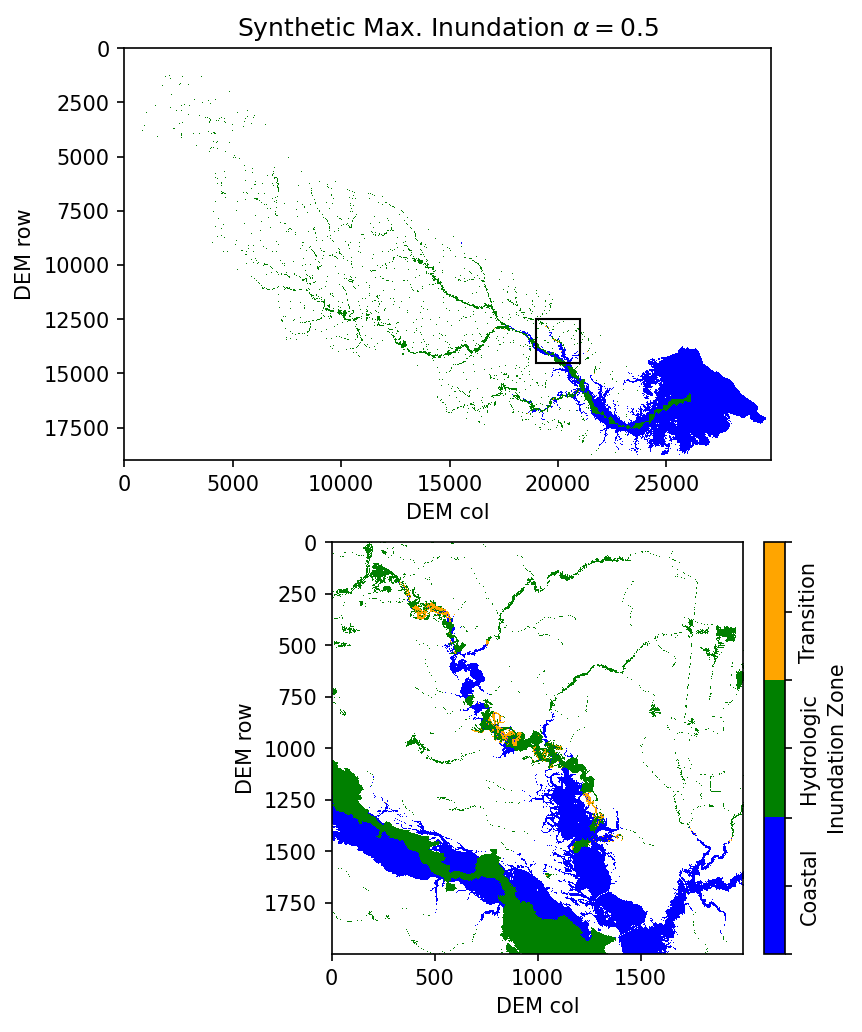

In [5]:
plt.close('all')

fig, ax = plt.subplots(2,1,figsize=(6,8),facecolor='w')

# detail window
rec_tl = (19000,12500) # top left (x, y)
dw, dh = 2000, 2000 # width, height of rec

cax0 = ax[0].imshow(
    florence_max,
    vmin=0,
    vmax=2,
    cmap=transition_cmap,
    interpolation='nearest'
    )

ax[0].set(
    title=fr'Synthetic Max. Inundation $\alpha = {alpha}$',
    xlabel='DEM col',
    ylabel='DEM row'
    )

# plot detail window on full map
ax[0].add_patch(Rectangle(
    rec_tl,
    dw,dh,
    fill=False,
    color='k')
    )

cax1 = ax[1].imshow(
    florence_max[
        rec_tl[1]:rec_tl[1]+dh,
        rec_tl[0]:rec_tl[0]+dw
        ],
    vmin=0,
    vmax=2,
    cmap=transition_cmap,
    interpolation='nearest'
        )

cbar = fig.colorbar(
    cax1,
    label='Inundation Zone',
    ticks=[0,0.33,0.663,1,1.33,1.66,2],
    ax=ax[1],
    fraction=0.046,
    pad=0.03
    )

cbar.ax.set_yticklabels(
    ['','Coastal','','Hydrologic','','Transition',''],
    rotation=90,
    va='center' # set vertical alignment
    )

ax[1].set(
    xlabel='DEM col',
    ylabel='DEM row'
    )

plt.show()

# # write raster with internal mask (no .msk sidecar)
# with rio.Env(GDAL_TIFF_INTERNAL_MASK=True):
#     with rio.open('data_github/synth_max_transition_alpha_05_noadj.tif', 'w', **surge_inun_profile) as ds_out:
#         ds_out.write(florence_max,1)
#         ds_out.write_mask(w_msk)

### Vary alpha for calcs

In [6]:
alpha_step = 0.05
alphalist = np.arange(
    0,
    1+alpha_step,
    alpha_step
    )

### Define animation loop called at each frame

In [7]:
def animate(i):
    
    alpha = alphalist[i]

    florence_max = couple_transition_anim(
        surge_inun = surge_inun,
        riv_inun = riv_inun,
        ratio_array = ratio_array,
        alpha = alpha # see eqn. 2 in SI 2022 paper
        )

    cax0.set_data(
        florence_max
        )

    cax1.set_data(
        florence_max[
            rec_tl[1]:rec_tl[1]+dh,
            rec_tl[0]:rec_tl[0]+dw
        ],
        )
        
    ax[0].set(
        title=fr'Synthetic Max. Inundation $\alpha = {round(alpha,2)}$'
        )

    return (cax0,cax1,)

### Make animation object

In [8]:
frames = list(range(len(alphalist)))

anim = matplotlib.animation.FuncAnimation(
    fig,
    animate, 
    frames=frames,
    interval=100,
    blit=True
    )

### Save animation

In [9]:
plt.close('all')

In [10]:
plt.close('all')
anim.save('data_github/alpha_anim_3fps.gif', writer='imagemagick', fps=3)

### Show animation